In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Classification of thoracic X-rays

> In this tutorial we will build a classifier that distinguishes between X-rays with pneumothorax and X-rays without pneumothorax.

## Import X-rays

### Loading the data with `Datasets`

TODO: UPDATE TEXT: To load the data with the medium-level API `Datasets`, we need to gather all the images and define some way to split them between training and validation sets.

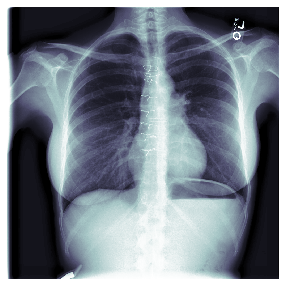

In [ ]:
pneumothorax_source = Path("/home/moritz/Documents/siim/")

# TODO: create small dataset and use the following structure:
# pneumothorax_source = untar_data(URLs.XRAY_TINY)

items = get_dicom_files(pneumothorax_source/f"dicom-images-train/")
trn,val = RandomSplitter()(items)

items[0].dcmread().show()

TODO: UPDATE TEXT: Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

Next, we need to load the labels for the dataset. In this case, the labels indicate whether the xray shows a pneumothorax or not.

In [ ]:
df = pd.read_csv("/home/moritz/Documents/siim/train-binary-classification.csv")
df.head()

,ImageId,Pneumothorax,Folder
0,1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,No Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.6904.1517875201.850818/1.2.276.0.7230010.3.1.3.8323329.6904.1517875201.850817/1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819.dcm
1,1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800,Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.13666.1517875247.117799/1.2.276.0.7230010.3.1.3.8323329.13666.1517875247.117798/1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800.dcm
2,1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789,No Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11028.1517875229.983788/1.2.276.0.7230010.3.1.3.8323329.11028.1517875229.983787/1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789.dcm
3,1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986,Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10366.1517875223.393985/1.2.276.0.7230010.3.1.3.8323329.10366.1517875223.393984/1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986.dcm
4,1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175,Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10016.1517875220.992174/1.2.276.0.7230010.3.1.3.8323329.10016.1517875220.992173/1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175.dcm


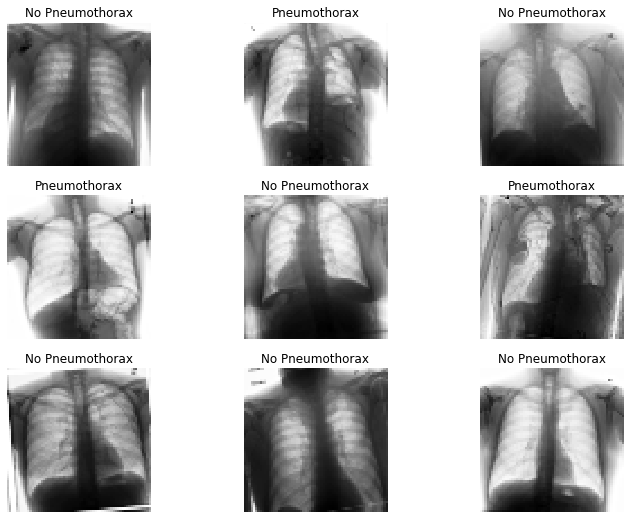

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=lambda x:x[2],
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=64, flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

We can then pass all of this information to `Datasets`.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.825925,0.569779,0.718533,00:31


In [ ]:
learn.predict("/home/moritz/Documents/siim/dicom-images-test/_/thorax-xrays/ID_0011fe81e.dcm")

('No Pneumothorax', tensor(0), tensor([0.6814, 0.3186]))

In [ ]:
learn.tta(use_max=True)

(tensor([[0.8705, 0.3885],
         [0.9090, 0.2308],
         [0.9579, 0.3423],
         ...,
         [0.7709, 0.6884],
         [0.9523, 0.3243],
         [0.8901, 0.6535]]), TensorCategory([0, 1, 0,  ..., 0, 0, 0]))

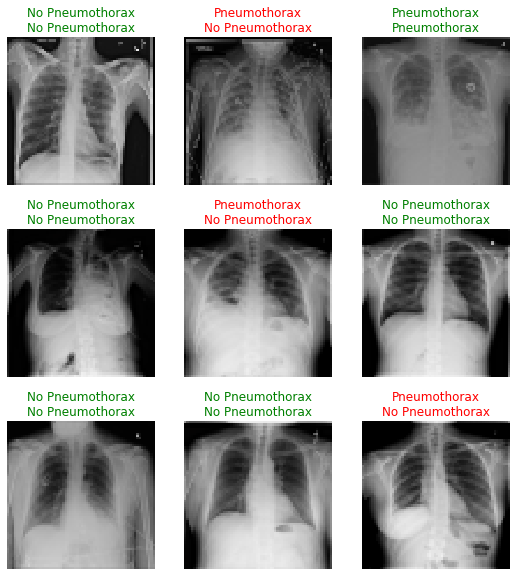

In [ ]:
learn.show_results(max_n=9)

In [ ]:
interp = Interpretation.from_learner(learn)

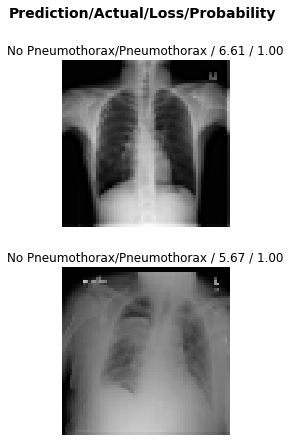

In [ ]:
interp.plot_top_losses(2)